In [6]:
import pandas as pd
import segyio
import shutil  # <-- IMPORTANTE: Usaremos a biblioteca padrão para copiar
from tqdm.notebook import tqdm
import sys
import os

# --- 1. Definição dos Nomes dos Arquivos ---
log_filename = 'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log'
segy_in_filename = 'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/SEG-Y/CAN_250821_D1_B_000.SEGY'
segy_out_filename = 'CAN_250821_D1_B_000_GEORREF.SEGY'


def carregar_navegacao(filename):
    """
    Lê o arquivo .log (que é um CSV sem cabeçalho) e o transforma
    em um dicionário de busca rápida.
    """
    print(f"Lendo arquivo de navegação: {filename} ...")
    
    if not os.path.exists(filename):
        print(f"ERRO: Arquivo de navegação '{filename}' NÃO ENCONTRADO.", file=sys.stderr)
        return None
        
    try:
        nav_df = pd.read_csv(filename, header=None, low_memory=False, dtype=str)
        
        clean_df = pd.DataFrame()
        
        # Índices corretos: FFID(1), X(12), Y(14)
        clean_df['FFID'] = pd.to_numeric(nav_df[1], errors='coerce')
        clean_df['X'] = pd.to_numeric(nav_df[12], errors='coerce') 
        clean_df['Y'] = pd.to_numeric(nav_df[14], errors='coerce') 
        
        original_count = len(clean_df)
        clean_df = clean_df.dropna()
        final_count = len(clean_df)
        
        print(f"Linhas lidas: {original_count}. Linhas válidas (com X,Y,FFID): {final_count}")

        if final_count == 0:
            print("ERRO: Nenhuma linha de navegação válida foi encontrada.", file=sys.stderr)
            return None

        clean_df['FFID'] = clean_df['FFID'].astype(int)
        clean_df = clean_df.set_index('FFID')
        
        nav_dict = clean_df.to_dict('index')
        print(f"Encontradas {len(nav_dict)} posições de navegação válidas.")
        return nav_dict
        
    except Exception as e:
        print(f"ERRO ao ler o arquivo de navegação: {e}", file=sys.stderr)
        return None


# --- FUNÇÃO 'injetar_geometria' CORRIGIDA ---
def injetar_geometria(nav_dict, segy_in, segy_out):
    """
    Copia o arquivo SEGY de entrada para o de saída, injetando
    as coordenadas X/Y do dicionário de navegação.
    """
    print(f"\nVerificando arquivo SEGY de entrada: {segy_in}")
    if not os.path.exists(segy_in):
        print(f"ERRO: Arquivo SEGY '{segy_in}' NÃO ENCONTRADO.", file=sys.stderr)
        return False
        
    try:
        # --- CORREÇÃO APLICADA AQUI ---
        # Usamos 'shutil.copy' (biblioteca padrão do Python) para
        # fazer uma cópia binária segura do arquivo.
        print(f"Criando cópia do arquivo: {segy_out} ...")
        shutil.copy(segy_in, segy_out)
        # --- FIM DA CORREÇÃO ---
        
        
        # --- 3. Abre o NOVO arquivo para modificação (modo 'r+') ---
        print(f"Arquivo copiado. Começando a injeção de geometria...")
        
        counter_success = 0
        counter_fail = 0
        
        # Agora abrimos o arquivo que ACABAMOS de copiar
        with segyio.open(segy_out, 'r+', ignore_geometry=True) as dst:
            total_traces = dst.tracecount
            
            for i in tqdm(range(total_traces), desc="Atualizando headers"):
                header = dst.header[i]
                # segyio.TraceField.FieldRecord é o padrão para o byte 9 (FFID)
                ffid = header[segyio.TraceField.FieldRecord]
                
                if ffid in nav_dict:
                    coords = nav_dict[ffid]
                    scalar_to_use = -100 # Escalar de -100 para 2 casas decimais
                    coord_x = round(coords['X'] * 100)
                    coord_y = round(coords['Y'] * 100)
                    
                    # Escreve nos campos de cabeçalho padrão
                    header[segyio.TraceField.SourceGroupScalar] = scalar_to_use
                    header[segyio.TraceField.SourceX] = coord_x
                    header[segyio.TraceField.SourceY] = coord_y
                    header[segyio.TraceField.GroupX] = coord_x
                    header[segyio.TraceField.GroupY] = coord_y
                    header[segyio.TraceField.CoordinateUnits] = 1 # Metros
                    
                    # Salva o cabeçalho modificado de volta no arquivo
                    dst.header[i] = header
                    counter_success += 1
                else:
                    counter_fail += 1

        print("\n--- Processamento Concluído! ---")
        print(f"Traços atualizados com sucesso: {counter_success}")
        print(f"Traços não encontrados no log: {counter_fail}")
        print(f"Arquivo final salvo como: {segy_out_filename}")
        print(f"Você pode encontrar este arquivo na mesma pasta do seu notebook.")
        return True
        
    except Exception as e:
        print(f"ERRO durante o processamento do SEGY: {e}", file=sys.stderr)
        return False

# --- Ponto de Entrada Principal ---
print(f"Arquivo Log a ser lido: {log_filename}")
print(f"Arquivo SEGY a ser lido: {segy_in_filename}")
print("--- INICIANDO PROCESSAMENTO ---")

mapa_navegacao = carregar_navegacao(log_filename)

if mapa_navegacao:
    injetar_geometria(mapa_navegacao, segy_in_filename, segy_out_filename)
else:
    print("\nProcessamento interrompido pois o arquivo de navegação não foi carregado.")

Arquivo Log a ser lido: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log
Arquivo SEGY a ser lido: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/SEG-Y/CAN_250821_D1_B_000.SEGY
--- INICIANDO PROCESSAMENTO ---
Lendo arquivo de navegação: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log ...
Linhas lidas: 8434. Linhas válidas (com X,Y,FFID): 8434
Encontradas 8434 posições de navegação válidas.

Verificando arquivo SEGY de entrada: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/SEG-Y/CAN_250821_D1_B_000.SEGY
Criando cópia do arquivo: CAN_250821_D1_B_000_GEORREF.SEGY ...
Arquivo copiado. Começando a injeção de geometria...


Atualizando headers:   0%|          | 0/8434 [00:00<?, ?it/s]


--- Processamento Concluído! ---
Traços atualizados com sucesso: 8434
Traços não encontrados no log: 0
Arquivo final salvo como: CAN_250821_D1_B_000_GEORREF.SEGY
Você pode encontrar este arquivo na mesma pasta do seu notebook.


Lendo o arquivo de log: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log
Plotando 8434 pontos da rota...
Gráfico salvo como 'mapa_da_rota.png'


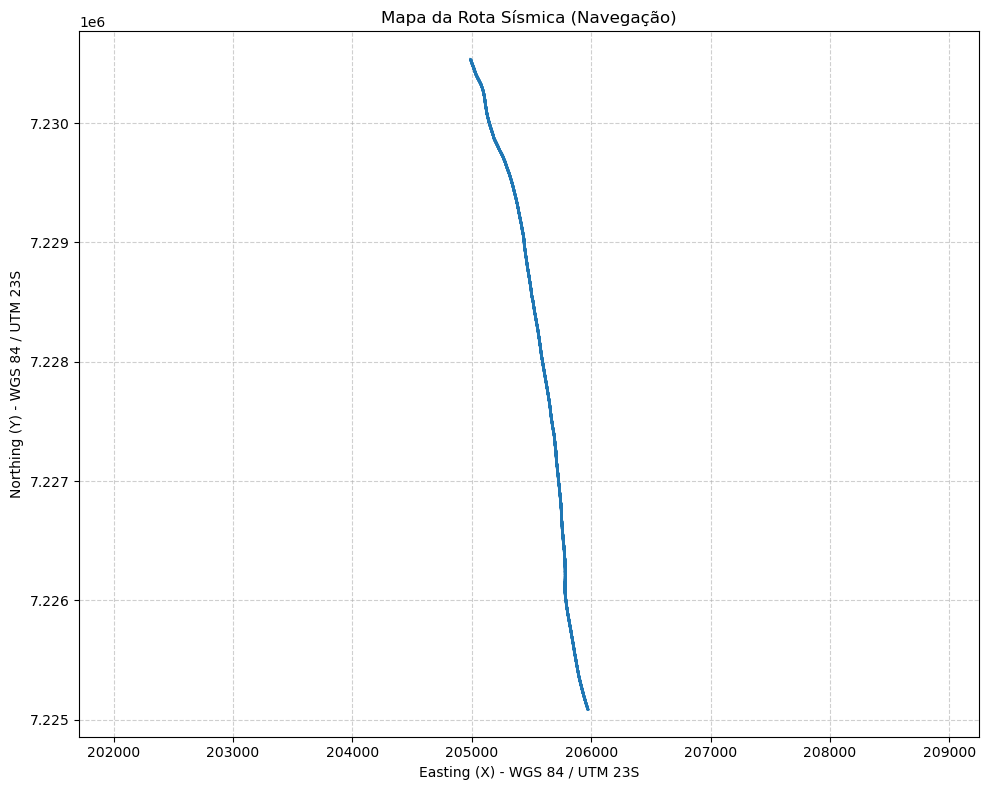

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. Definição do Nome do Arquivo de Log ---
log_filename = 'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log'

print(f"Lendo o arquivo de log: {log_filename}")

try:
    # --- 2. Leitura e Limpeza dos Dados (o mesmo método de antes) ---
    nav_df = pd.read_csv(log_filename, header=None, low_memory=False, dtype=str)
    
    # Índices corretos: X(12), Y(14)
    x_coords = pd.to_numeric(nav_df[12], errors='coerce') 
    y_coords = pd.to_numeric(nav_df[14], errors='coerce') 
    
    # Cria um dataframe limpo para plotagem
    plot_data = pd.DataFrame({'X': x_coords, 'Y': y_coords}).dropna()
    
    # --- 3. Plotagem com Matplotlib ---
    if not plot_data.empty:
        print(f"Plotando {len(plot_data)} pontos da rota...")
        
        plt.figure(figsize=(10, 8))
        plt.plot(plot_data['X'], plot_data['Y'], marker='.', markersize=1, linestyle='-')
        
        # Títulos e Labels
        plt.title('Mapa da Rota Sísmica (Navegação)')
        plt.xlabel('Easting (X) - WGS 84 / UTM 23S')
        plt.ylabel('Northing (Y) - WGS 84 / UTM 23S')
        
        # Configurações do Gráfico
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axis('equal') # MUITO IMPORTANTE: Mantém a proporção X/Y correta
        plt.tight_layout()
        
        # Salva a imagem (opcional) e mostra na tela
        plt.savefig("mapa_da_rota.png")
        print("Gráfico salvo como 'mapa_da_rota.png'")
        plt.show()
        
    else:
        print("ERRO: Não foi possível extrair dados X,Y para plotar.")
        
except FileNotFoundError:
    print(f"ERRO: Arquivo de log não encontrado no caminho: {log_filename}", file=sys.stderr)
except Exception as e:
    print(f"Um erro ocorreu durante a plotagem: {e}", file=sys.stderr)

Pasta 'mag-processamento/plots_navegacao' criada para salvar os mapas.
--- INICIANDO PROCESSAMENTO DE VÁRIOS LOGS ---

Processando arquivo: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log
  -> Encontrados 8434 pontos válidos.
  -> Mapa individual salvo em: mag-processamento/plots_navegacao/mapa_individual_18662075.png

Processando arquivo: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D2_B/18662075.log
  -> Encontrados 15894 pontos válidos.
  -> Mapa individual salvo em: mag-processamento/plots_navegacao/mapa_individual_18662075.png

Processando arquivo: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_D3_b/18662075.log
  -> Encontrados 14079 pontos válidos.
  -> Mapa individual salvo em: mag-processamento/plots_navegacao/mapa_individual_18662075.png

Processando arquivo: mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_D4_b/18662075.log
  -> Encontrados 1824 pontos válidos.
  -> M

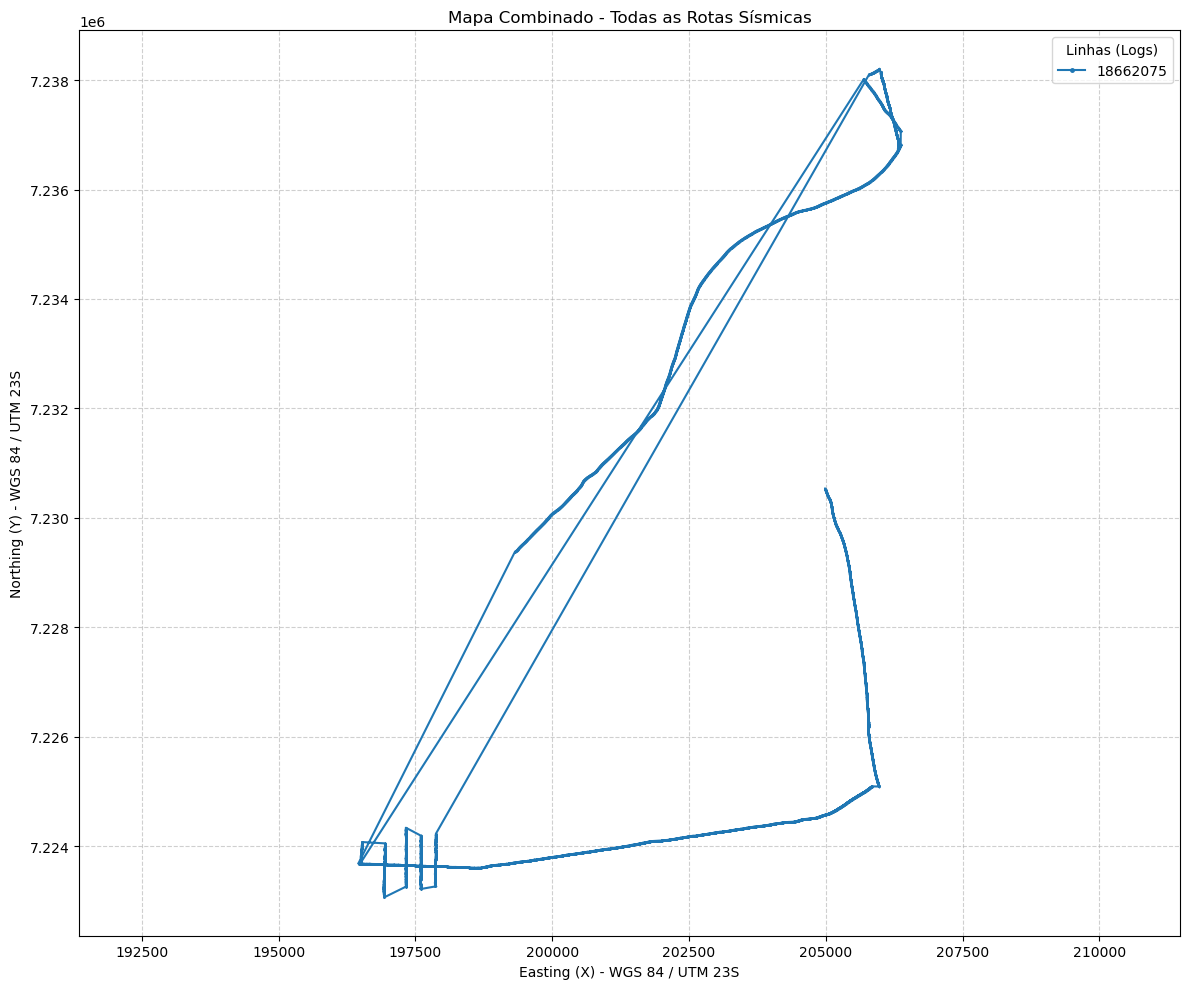


--- Processamento de todos os logs concluído! ---


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# --- 1. CONFIGURAÇÃO ---
# (Coloque os caminhos completos, como você já fez)


lista_de_logs = [
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D1_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_D2_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_D3_b/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_D4_b/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_S1_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_S2_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_S3_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_S4_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/CAN_250821_S5_B/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_S6_b/18662075.log',
    'mag-processamento/Survey_Caneneia_08_2025/SISMICA_21_08_25/can_250821_C2_b/18662075.log',
    
   
]

# --- 2. PREPARAÇÃO ---
output_plot_folder = 'mag-processamento/plots_navegacao'
if not os.path.exists(output_plot_folder):
    os.makedirs(output_plot_folder)
    print(f"Pasta '{output_plot_folder}' criada para salvar os mapas.")
    
all_dataframes = []

print("--- INICIANDO PROCESSAMENTO DE VÁRIOS LOGS ---")

# --- 3. LOOP PARA PLOTS INDIVIDUAIS ---

for full_log_path in lista_de_logs:
    log_name = os.path.basename(full_log_path) 
    print(f"\nProcessando arquivo: {full_log_path}")
    
    try:
        nav_df = pd.read_csv(full_log_path, header=None, low_memory=False, dtype=str)
        
        plot_data = pd.DataFrame({
            'X': pd.to_numeric(nav_df[12], errors='coerce'),
            'Y': pd.to_numeric(nav_df[14], errors='coerce')
        }).dropna()
        
        if plot_data.empty:
            print(f"  -> Aviso: Nenhum dado X,Y válido encontrado em {log_name}. Pulando.")
            continue
            
        print(f"  -> Encontrados {len(plot_data)} pontos válidos.")
        
        line_label = log_name.replace('.log', '') 
        plot_data['Linha'] = line_label
        
        all_dataframes.append(plot_data)
        
        # --- Plot Individual ---
        plt.figure(figsize=(10, 8))
        plt.plot(plot_data['X'], plot_data['Y'], marker='.', markersize=1, linestyle='-')
        plt.title(f'Mapa da Rota - {line_label}')
        plt.xlabel('Easting (X) - WGS 84 / UTM 23S')
        plt.ylabel('Northing (Y) - WGS 84 / UTM 23S')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.axis('equal')
        plt.tight_layout()
        
        output_filename = os.path.join(output_plot_folder, f'mapa_individual_{line_label}.png')
        plt.savefig(output_filename)
        print(f"  -> Mapa individual salvo em: {output_filename}")
        plt.close() 
        
    except FileNotFoundError:
        print(f"  -> ERRO: Arquivo não encontrado: {full_log_path}", file=sys.stderr)
    except Exception as e:
        print(f"  -> ERRO ao processar {log_name}: {e}", file=sys.stderr)

# --- Verificação antes de continuar ---
if not all_dataframes:
    print("\nNenhum dado foi lido. Não é possível gerar os arquivos combinados.")
else:
    # --- 4. SALVAR ARQUIVO DE DADOS COMBINADO (PARA QGIS) ---
    #
    #   ESTA É A PARTE NOVA QUE VOCÊ PEDIU!
    #
    print("\n--- Gerando Arquivo de Dados Combinado ---")
    
    # Concatena todos os dataframes da lista em um só
    combined_data = pd.concat(all_dataframes)
    
    # Define o nome do arquivo CSV de saída
    csv_output_filename = os.path.join(output_plot_folder, 'dados_combinados_TODAS_AS_ROTAS.csv')
    
    try:
        # Salva o DataFrame combinado em um arquivo CSV
        # index=False evita salvar o índice do pandas no arquivo
        combined_data.to_csv(csv_output_filename, index=False)
        
        print(f"Arquivo CSV com todas as rotas salvo em: {csv_output_filename}")
        print(">>> Você pode arrastar este arquivo CSV para o QGIS! <<<")
        
    except Exception as e:
        print(f"Erro ao salvar arquivo CSV: {e}", file=sys.stderr)

    # --- 5. PLOT COMBINADO (IMAGEM) ---
    print("\n--- Gerando Mapa Combinado (Imagem) ---")
    
    plt.figure(figsize=(12, 10))
    
    for line_label, group_data in combined_data.groupby('Linha'):
        plt.plot(group_data['X'], group_data['Y'], marker='.', markersize=0.5, linestyle='-', label=line_label)
        
    plt.title('Mapa Combinado - Todas as Rotas Sísmicas')
    plt.xlabel('Easting (X) - WGS 84 / UTM 23S')
    plt.ylabel('Northing (Y) - WGS 84 / UTM 23S')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.legend(title="Linhas (Logs)", markerscale=10) 
    plt.tight_layout()
    
    output_filename_combined = os.path.join(output_plot_folder, 'mapa_combinado_TODAS_AS_ROTAS.png')
    plt.savefig(output_filename_combined)
    print(f"Mapa (imagem) combinado salvo em: {output_filename_combined}")
    plt.show() 

print("\n--- Processamento de todos os logs concluído! ---")